# DO LSTM Model Post-Hoc Analysis
## Harrison Myers
### 12/6/2024

This script conducts post-hoc analysis on the pretrained, finetuned, and site only LSTMs for floodplain DO prediction. 

In [1]:
import os
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.preprocessing import MinMaxScaler


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
proj_dir = os.getcwd()
os.chdir(proj_dir)

In [3]:
OC2 = pd.read_csv(proj_dir + r"/data/OC2.csv", index_col=[0])
OC2.index = pd.to_datetime(OC2.index).date
LF1 = pd.read_csv(proj_dir + r"/data/LF1.csv", index_col=[0])
LF1.index = pd.to_datetime(LF1.index).date
LF2 = pd.read_csv(proj_dir + r"/data/LF2.csv", index_col=[0])
LF2.index = pd.to_datetime(LF2.index).date
OC4 = pd.read_csv(proj_dir + r"/data/OC4.csv", index_col=[0])
OC4.index = pd.to_datetime(OC4.index).date
LF3 = pd.read_csv(proj_dir + r"/data/LF3.csv", index_col=[0])
LF3.index = pd.to_datetime(LF3.index).date
OC1 = pd.read_csv(proj_dir + r"/data/OC1.csv", index_col=[0])
OC1.index = pd.to_datetime(OC1.index).date
OC3 = pd.read_csv(proj_dir + r"/data/OC3.csv", index_col=[0])
OC3.index = pd.to_datetime(OC3.index).date

In [4]:
OC2_noNA = OC2.dropna(subset=['o'])
LF1_noNA = LF1.dropna(subset=['o'])
LF2_noNA = LF2.dropna(subset=['o'])
OC4_noNA = OC4.dropna(subset=['o'])
LF3_noNA = LF3.dropna(subset=['o'])
OC1_noNA = OC1.dropna(subset=['o'])
OC3_noNA = OC3.dropna(subset=['o'])

In [5]:
site_dfs_noNA = [OC2_noNA, LF1_noNA, LF2_noNA, OC4_noNA, LF3_noNA, OC1_noNA, OC3_noNA]

In [6]:
data = pd.read_csv(proj_dir + r"/data/river_training_data.csv", index_col=[0])
data.index = pd.to_datetime(data.index).date
data.head()

data_noNA = data.dropna(subset=['o'])
print(data_noNA.shape)

### Data preprocessing

In [7]:
with open(proj_dir + '/vars_to_keep_FS.txt', "r") as file:
    vars_to_keep = [line.strip() for line in file]

for i, df in enumerate(site_dfs_noNA):
    df = df[vars_to_keep]
    df = df.sort_index(axis=1)
    site_dfs_noNA[i] = df
data = data[vars_to_keep]
data_noNA = data_noNA[vars_to_keep]
master_noNA = pd.concat(site_dfs_noNA)

In [8]:
river_site_dfs = {}
data_noNA['site'] = data_noNA.groupby(['lat', 'lon']).ngroup()
sites = data_noNA['site'].unique()
for site in sites:
    temp_df = data_noNA[data_noNA['site'] == site]
    if len(temp_df) >= 365: # only keep sites with a year or more worth of data
        temp_df = temp_df.drop('site', axis=1)
        river_site_dfs[site] = temp_df
    else:
        data_noNA = data_noNA[data_noNA['site'] != site]
    river_site_dfs[site] = temp_df
    
data_noNA.drop('site', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
data_noNA = data_noNA.sort_index(axis=1)
master_noNA = master_noNA.sort_index(axis=1)

In [10]:
# create a dataframe with USGS and site data for accurate scaling
all_data_df = pd.concat([master_noNA, data_noNA])
all_data_df = all_data_df.sort_index(axis=1)

# First fit scaler just to y data for rescaling predictions
scaler_y = MinMaxScaler()
scaler_y.fit(np.array(all_data_df["o"]).reshape(-1, 1))

# Scale dataset
scaler = MinMaxScaler()
scaler.fit(all_data_df.values)

In [11]:
from utils import preprocessing_functions as ppf
data_sc = ppf.data_pipeline(data, 1e-7, scaler)
data_sc_noNA = ppf.data_pipeline(data_noNA, 1e-7, scaler)

MinMaxScaler()

In [12]:
site_dfs_sc_noNA = []
for df in site_dfs_noNA:
    df_sc = ppf.data_pipeline(df, 1e-7, scaler)
    site_dfs_sc_noNA.append(df_sc)

In [15]:
window_length = 10
hidden_layers = 1
hidden_units = 8
batch_size = 256
n_epochs = 150
activation_dense = 'relu'
learning_rate = 0.0008
dropout = 0.2

In [16]:
import h5py

# Load weights from the HDF5 file
with h5py.File(proj_dir + 'model_weights/River_LSTM.weights.h5', 'r') as f:
    layer_names = list(f['/layers'].keys())  # Get the order of layers
    print("Layer names:", layer_names)
    
    for layer_name in layer_names:
        layer_group = f['/layers'][layer_name]
        print(f"\nMembers of layer '{layer_name}':")
        
        for member_name in layer_group.keys():
            print(f"  {member_name} (type: {type(layer_group[member_name])})")
            
            # If the member is a group, further inspect its contents
            member_group = layer_group[member_name]
            if isinstance(member_group, h5py.Group):
                for sub_member_name in member_group.keys():
                    sub_member = member_group[sub_member_name]
                    print(f"    {sub_member_name} (type: {type(sub_member)})")
                    
                    # If it's a dataset, print its shape and dtype
                    if isinstance(sub_member, h5py.Dataset):
                        print(f"      Shape: {sub_member.shape}, Dtype: {sub_member.dtype}")

                    # If it's another group, further delve into it
                    elif isinstance(sub_member, h5py.Group):
                        print(f"    Inspecting nested group '{sub_member_name}' in '{layer_name}':")
                        for nested_name in sub_member.keys():
                            nested_member = sub_member[nested_name]
                            print(f"      {nested_name} (type: {type(nested_member)})")
                            if isinstance(nested_member, h5py.Dataset):
                                print(f"        Shape: {nested_member.shape}, Dtype: {nested_member.dtype}")
                        

Layer names: ['dense', 'dropout', 'lstm']

Members of layer 'dense':
  vars (type: <class 'h5py._hl.group.Group'>)
    0 (type: <class 'h5py._hl.dataset.Dataset'>)
      Shape: (8, 1), Dtype: float32
    1 (type: <class 'h5py._hl.dataset.Dataset'>)
      Shape: (1,), Dtype: float32

Members of layer 'dropout':
  vars (type: <class 'h5py._hl.group.Group'>)

Members of layer 'lstm':
  cell (type: <class 'h5py._hl.group.Group'>)
    vars (type: <class 'h5py._hl.group.Group'>)
    Inspecting nested group 'vars' in 'lstm':
      0 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (35, 32), Dtype: float32
      1 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (8, 32), Dtype: float32
      2 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (32,), Dtype: float32
  vars (type: <class 'h5py._hl.group.Group'>)


In [17]:
seed = 2619
window_length = 8
batch_size = 4
n_epochs = 150
learning_rate = 0.00008
smoothing_level = 0.8
stop_patience = 15
dropout = 0.3

In [18]:
# Smooth data
site_dfs_smoothed = []
for df in site_dfs_noNA:
    df_sm = df.copy()
    fit = SimpleExpSmoothing(df_sm['o'], initialization_method="heuristic").fit(
    smoothing_level=smoothing_level, optimized=False)
    df_sm['o'] = fit.fittedvalues
    df_sm = df_sm.sort_index(axis=1)
    site_dfs_smoothed.append(df_sm)
    
# Scale smoothed data
site_dfs_sc = []
for df in site_dfs_smoothed:
    df_sc = ppf.data_pipeline(df, 1e-7, scaler)
    site_dfs_sc.append(df_sc)
    
# Split smoothed data into training and testing
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

print("Loading train/test split indices")
list_of_tuples = []
with open(proj_dir + "/model_weights/best/train_test_split_indices.txt", "r") as file:
    for line in file:
        text = line.strip().split(", ")
        list_of_tuples.append((text[0], int(text[1]), int(text[2])))
sites, start_inds, end_inds = zip(*list_of_tuples)
for i, df in enumerate(site_dfs_sc):
    test_df = df[start_inds[i]:end_inds[i]]
    train_df = pd.concat([df[:start_inds[i]], df[end_inds[i]:]])
    X_train = train_df.drop('o', axis=1)
    y_train = train_df['o']
    X_test = test_df.drop('o', axis=1)
    y_test = test_df['o']
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)    

X_train_master = pd.concat(X_train_list)
y_train_master = pd.concat(y_train_list)
X_test_master = pd.concat(X_test_list)
y_test_master = pd.concat(y_test_list)

Loading train/test split indices


A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
No frequency information was provided, so inferred frequency D will be used.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


In [19]:
X_OC2, y_OC2 = ppf.reshape_data(site_dfs_sc[0].drop(['o'], axis=1), site_dfs_sc[0]['o'], window_length)
X_LF1, y_LF1 = ppf.reshape_data(site_dfs_sc[1].drop(['o'], axis=1), site_dfs_sc[1]['o'], window_length)
X_LF2, y_LF2 = ppf.reshape_data(site_dfs_sc[2].drop(['o'], axis=1), site_dfs_sc[2]['o'], window_length)
X_OC4, y_OC4 = ppf.reshape_data(site_dfs_sc[3].drop(['o'], axis=1), site_dfs_sc[3]['o'], window_length)
X_LF3, y_LF3 = ppf.reshape_data(site_dfs_sc[4].drop(['o'], axis=1), site_dfs_sc[4]['o'], window_length)
X_OC1, y_OC1 = ppf.reshape_data(site_dfs_sc[5].drop(['o'], axis=1), site_dfs_sc[5]['o'], window_length)
X_OC3, y_OC3 = ppf.reshape_data(site_dfs_sc[6].drop(['o'], axis=1), site_dfs_sc[6]['o'], window_length)
X_master_rs = np.concatenate([X_OC2, X_LF1, X_LF2, X_OC4, X_LF3, X_OC1, X_OC3], axis=0)
np.random.shuffle(X_master_rs)
y_master_rs = np.concatenate([y_OC2, y_LF1, y_LF2, y_OC4, y_LF3, y_OC1, y_OC3])

In [20]:
print(X_master_rs.shape)

(3755, 7, 35)


In [21]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
from untils import model_building_training_functions as mbf
with h5py.File(proj_dir + '/model_weights/best/River_LSTM.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        n_features = len(X_train_master.columns)
        model = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model.layers[2].set_weights(dense_weights)
        
        explainer_PT = shap.DeepExplainer(model, X_master_rs[:1000], session=sess)
        shap_values_PT = explainer_PT.shap_values(X_master_rs[:1000])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2024-12-18 14:04:06.839917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-12-18 14:04:06.883420: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 14:04:06.883450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3050 Ti Laptop GPU major: 8 minor: 6 memoryClockRate(GHz): 1.035
pciBusID: 0000:01:00.0
2024-12-18 14:04:06.883546: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2024-12-18 14:04:06.883605: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: c

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1408      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Create Explanation object from shap values for plotting purposes
shap_explainer = shap.Explanation(values=shap_values_PT, base_values=explainer_PT.expected_value, data=X_master_rs[:1000])

# Average shap values and data over window lengths (e.g., remove window length and go from (100, 7, 35) to (100, 35))
shap_values_2d = shap_explainer[0].values.mean(axis=1)
data_2d = shap_explainer.data.mean(axis=1)

In [23]:
# Get list of feature names and drop target feature column
feature_names = list(site_dfs_noNA[0].columns)
feature_names.remove('o')
print(feature_names)
feature_name_dict = {'ARTIFICIAL': '% Artificial flowpaths',
                     'BASIN_AREA': "Catchment area",
                     'BEDPERM_6': "% Bedrock: unconsolidated sand and gravel",
                     'BFI': 'Baseflow index',
                     'CNPY11_BUFF100': "% Tree canopy in 100m riparian buffer",
                     'CONTACT': "Subsurface flow contact time (d)",
                     'ELEV_MAX': "Maximum catchment elevation (m)",
                     'ELEV_MEAN': "Mean elevation (m)",
                     'ELEV_MIN': 'Minimum catchment elevation (m)',
                     'FUNGICIDE': 'Fungicide use',
                     'HGAD': "% of hydrologic group AD soil",
                     'HGC': '% of hydrologic group C soil', 
                     'LAKEPOND': "% Lakes or ponds",
                     'N97': "Nitrogen from fertilizer/manure (1997)",
                     'NLCD01_52': "% Shrub/scrub",
                     'NLCD01_81': "% Pasture/hay",
                     'NLCD01_95': "% Emergent wetlands",
                     'RH': 'Relative humidity (%)',
                     'SALINAVE': 'Mean salinity (mohms/cm)',
                     'SANDAVE': 'Mean % sand',
                     'SILTAVE': "Mean % silt",
                     'STRM_DENS': "Stream density",
                     'WDANN': "Average days/year with precipitation",
                     'dayl (s)': 'Day length (s)',
                     'lat': 'Latitude',
                     'lon': 'Longitude',
                     'prcp (mm/day)': 'Precipitation (mm/day)',
                     'q': 'Discharge (cfs)',
                     'sinuosity': "Mean stream sinuosity",
                     'srad (W/m2)': "Solar radiation (W/m2)",
                     'swe (kg/m2)': "Snow-water equivalent (kg/m2)",
                     'temp': 'Water temperature (C)',
                     'tmax (degrees C)': "Maximum daily temperature (C)",
                     'tmin (degrees C)': "Minimum daily temperature (C)",
                     'vp (Pa)': "Vapor pressure (Pa)"
                     }
feature_names = list(feature_name_dict.values())
print(feature_names)

['ARTIFICIAL', 'BASIN_AREA', 'BEDPERM_6', 'BFI', 'CNPY11_BUFF100', 'CONTACT', 'ELEV_MAX', 'ELEV_MEAN', 'ELEV_MIN', 'FUNGICIDE', 'HGAD', 'HGC', 'LAKEPOND', 'N97', 'NLCD01_52', 'NLCD01_81', 'NLCD01_95', 'RH', 'SALINAVE', 'SANDAVE', 'SILTAVE', 'STRM_DENS', 'WDANN', 'dayl (s)', 'lat', 'lon', 'prcp (mm/day)', 'q', 'sinuosity', 'srad (W/m2)', 'swe (kg/m2)', 'temp', 'tmax (degrees C)', 'tmin (degrees C)', 'vp (Pa)']
['% Artificial flowpaths', 'Catchment area', '% Bedrock: unconsolidated sand and gravel', 'Baseflow index', '% Tree canopy in 100m riparian buffer', 'Subsurface flow contact time (d)', 'Maximum catchment elevation (m)', 'Mean elevation (m)', 'Minimum catchment elevation (m)', 'Fungicide use', '% of hydrologic group AD soil', '% of hydrologic group C soil', '% Lakes or ponds', 'Nitrogen from fertilizer/manure (1997)', '% Shrub/scrub', '% Pasture/hay', '% Emergent wetlands', 'Relative humidity (%)', 'Mean salinity (mohms/cm)', 'Mean % sand', 'Mean % silt', 'Stream density', 'Average

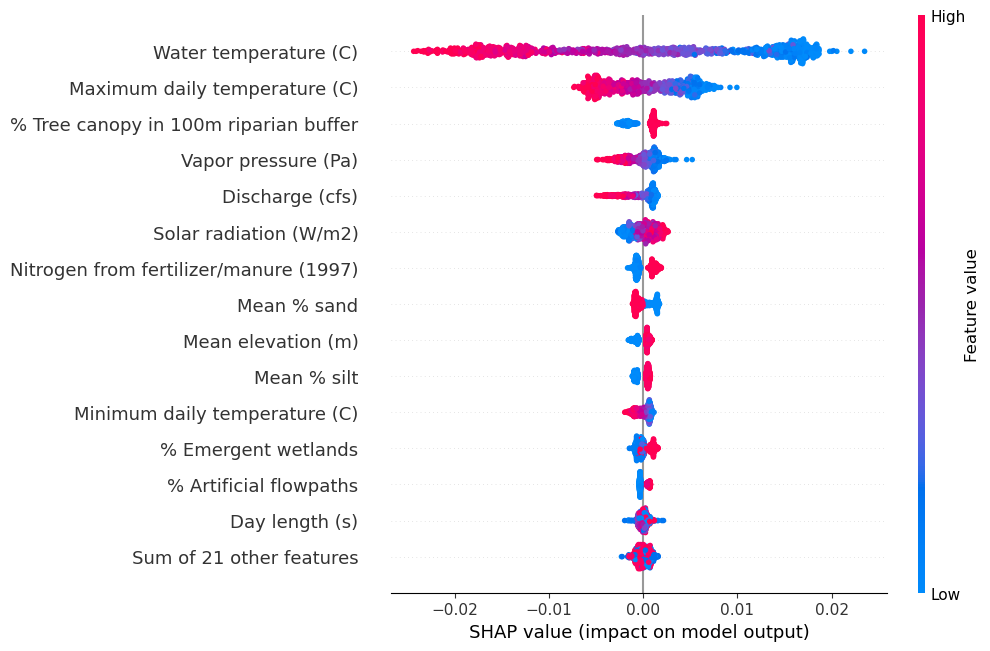

In [24]:
# Need to call this to be able to use shap plotting functions
shap.initjs()

# Get the expected value and 2D shap explainer object for plotting
expected_PT = np.repeat(explainer_PT.expected_value, 1000)
shap_explanation_2d = shap.Explanation(values=shap_values_2d, base_values=expected_PT, feature_names=feature_names, data=data_2d)

# Make beeswarm plot
shap.plots.beeswarm(shap_explanation_2d, max_display=15)

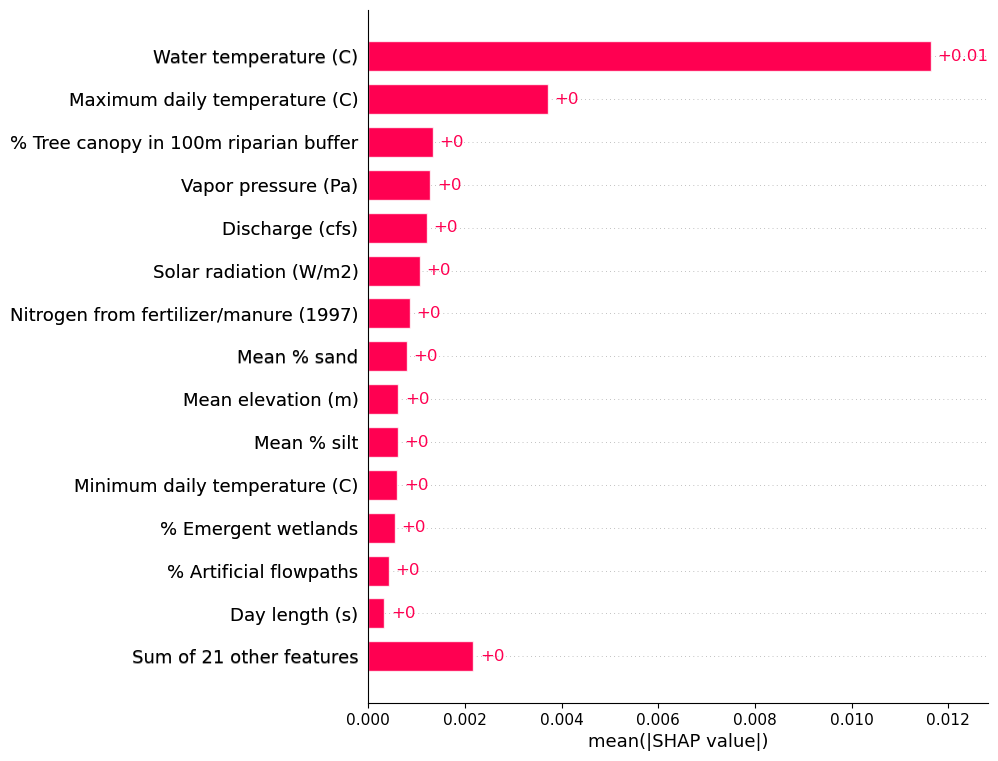

In [25]:
shap.plots.bar(shap_explanation_2d, max_display=15)

In [26]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File('model_weights/best/FT_MSE.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        n_features = len(X_train_master.columns)
        model_FT = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model_FT.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model_FT.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model_FT.layers[2].set_weights(dense_weights)
        
        explainer_FT = shap.DeepExplainer(model_FT, X_master_rs[:1000], session=sess)
        shap_values_FT = explainer_FT.shap_values(X_master_rs[:1000])

2024-12-18 14:04:55.759684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-12-18 14:04:55.759722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Create Explanation object from shap values for plotting purposes
shap_explainer_FT = shap.Explanation(values=shap_values_FT, base_values=explainer_FT.expected_value, data=X_master_rs[:1000])

# Average shap values and data over window lengths (e.g., remove window length and go from (100, 7, 35) to (100, 35))
shap_values_2d_FT = shap_explainer_FT[0].values.mean(axis=1)
data_2d_FT = shap_explainer_FT.data.mean(axis=1)

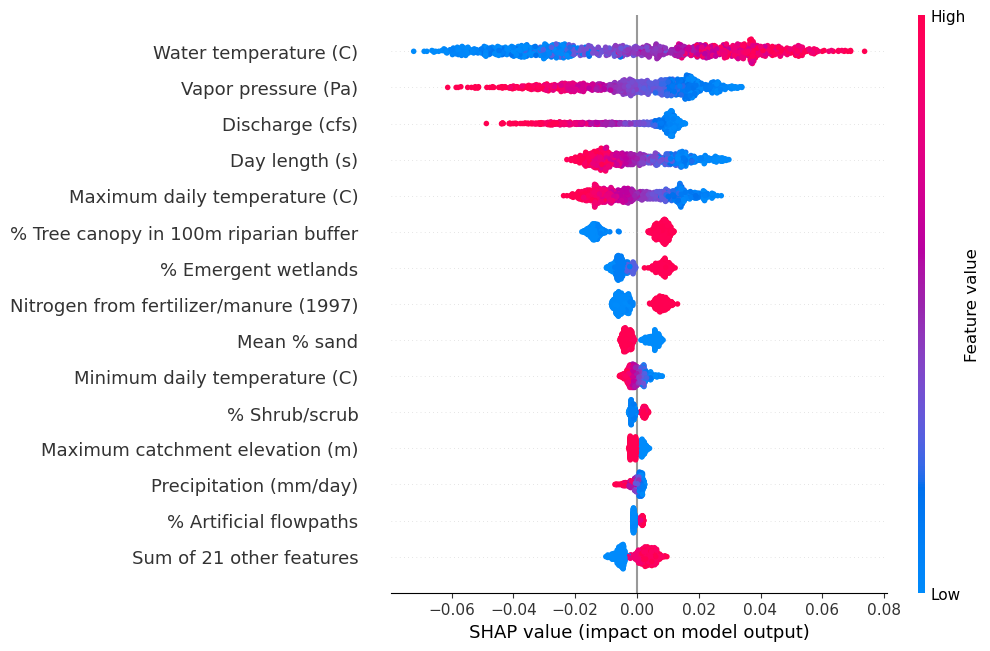

In [28]:
expected_FT = np.repeat(explainer_FT.expected_value, 1000)
shap_explanation_2d_FT = shap.Explanation(values=shap_values_2d_FT, base_values=expected_FT, feature_names=feature_names, data=data_2d_FT)
shap.plots.beeswarm(shap_explanation_2d_FT, max_display=15)

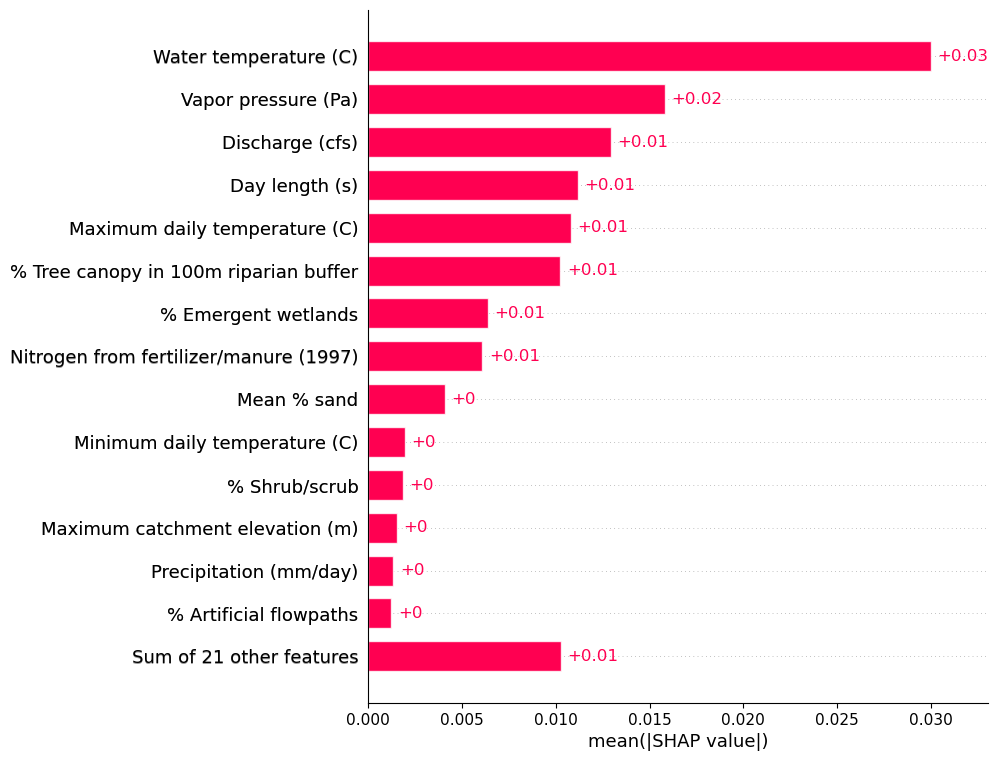

In [29]:
shap.plots.bar(shap_explanation_2d_FT, max_display=15)

In [30]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File('model_weights/best/FP_only_MSE.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        n_features = len(X_train_master.columns)
        model_FP = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model_FP.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model_FP.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model_FP.layers[2].set_weights(dense_weights)
        
        explainer_FP = shap.DeepExplainer(model_FP, X_master_rs[:1000], session=sess)
        shap_values_FP = explainer_FP.shap_values(X_master_rs[:1000])

2024-12-18 14:05:47.542208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-12-18 14:05:47.542236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create Explanation object from shap values for plotting purposes
shap_explainer_FP = shap.Explanation(values=shap_values_FP, base_values=explainer_FP.expected_value, data=X_master_rs[:1000])

# Average shap values and data over window lengths (e.g., remove window length and go from (100, 7, 35) to (100, 35))
shap_values_2d_FP = shap_explainer_FP[0].values.mean(axis=1)
data_2d_FP = shap_explainer_FP.data.mean(axis=1)

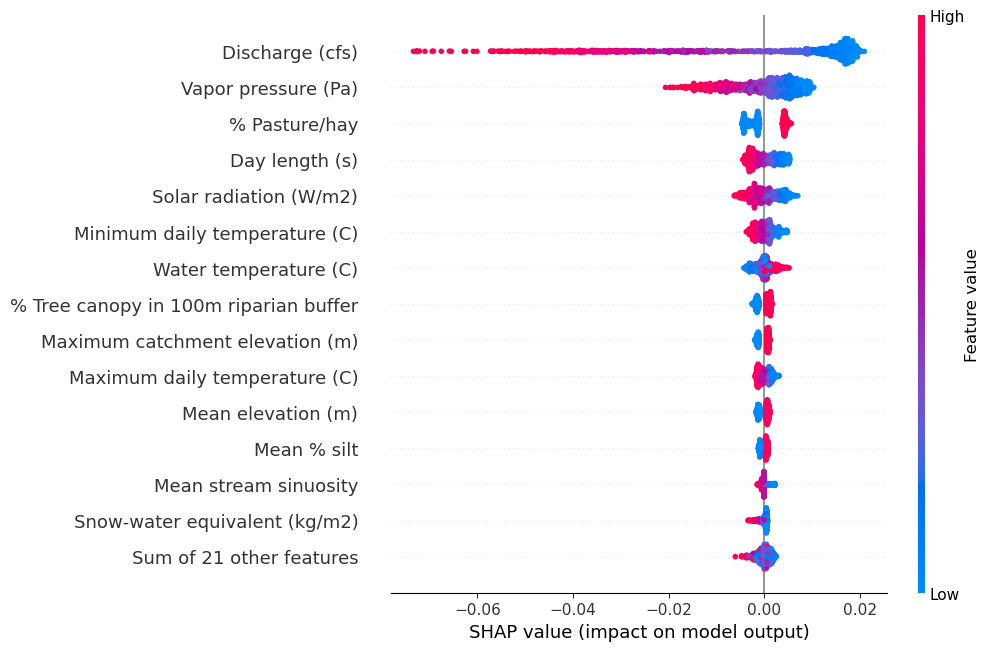

In [32]:
expected_FP = np.repeat(explainer_FP.expected_value, 1000)
shap_explanation_2d_FP = shap.Explanation(values=shap_values_2d_FP, base_values=expected_FP, feature_names=feature_names, data=data_2d_FP)
shap.plots.beeswarm(shap_explanation_2d_FP, max_display=15)

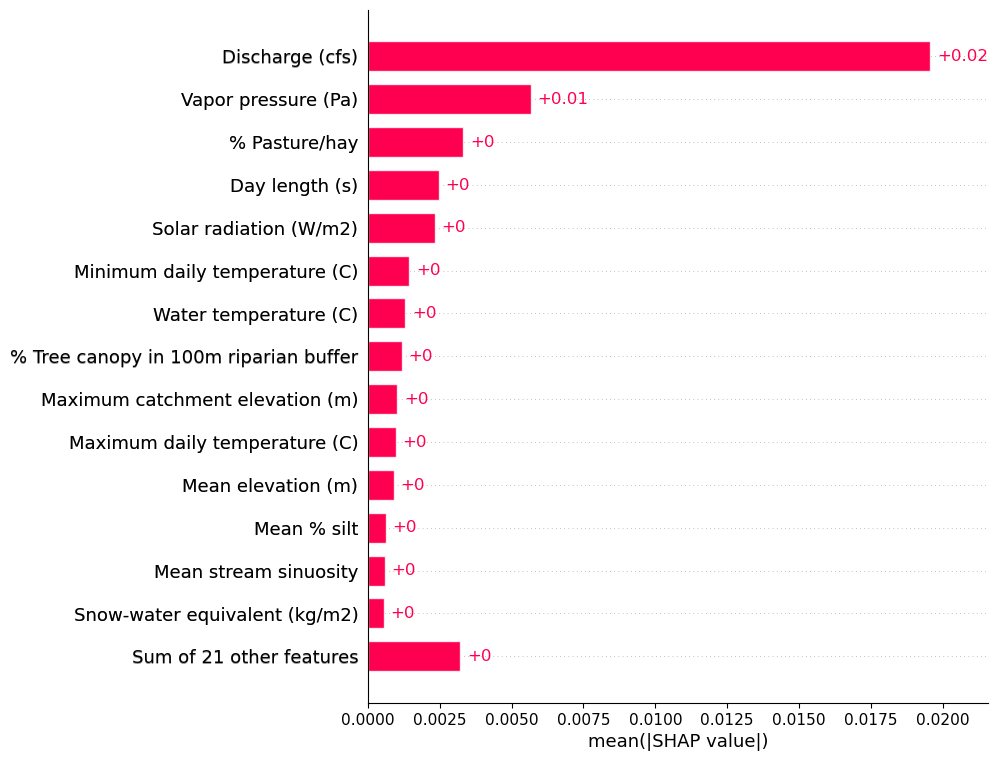

In [33]:
shap.plots.bar(shap_explanation_2d_FP, max_display=15)

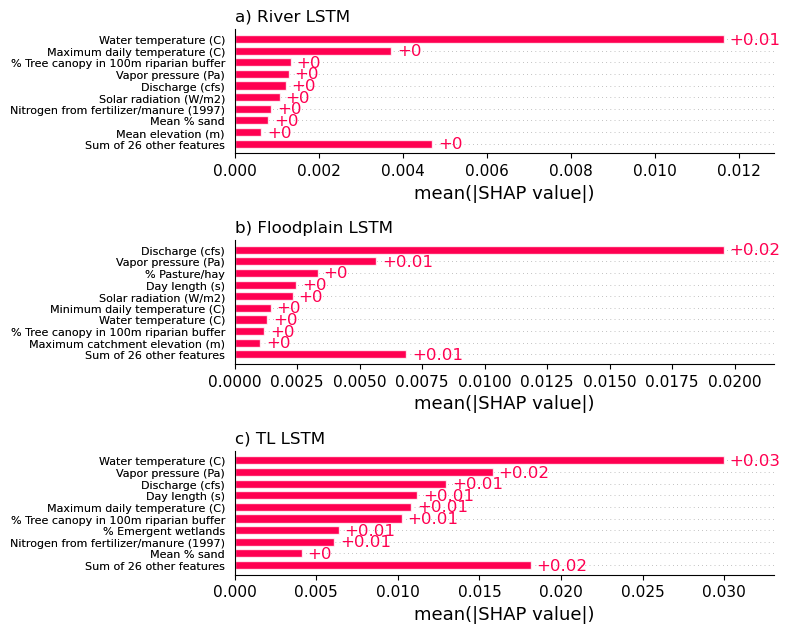

In [39]:
# Make figure of all plots
# List of SHAP explanation objects for your models
shap_explanations = [shap_explanation_2d,  shap_explanation_2d_FP, shap_explanation_2d_FT]
model_names = ["a) River LSTM", "b) Floodplain LSTM", "c) TL LSTM"]

# Create a figure with 3 rows and 2 columns
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(3, 1, figsize=(12, 24))

# Plot each model in a loop
for i, shap_exp in enumerate(shap_explanations):
    # Create bar plot in the first column (left)
    plt.sca(axs[i])
    shap.plots.bar(shap_exp, show=False)
    axs[i].set_title(f'{model_names[i]}', fontsize=12, loc='left')
    axs[i].tick_params(axis='y', labelsize=8) 

fig.tight_layout()
plt.savefig(proj_dir + '/figures/shapley_values/feature_importances.png', dpi=600)
plt.show()

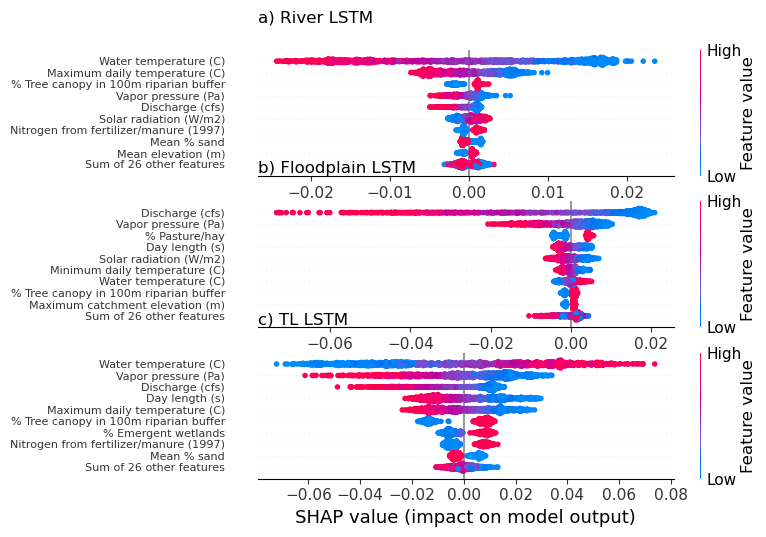

In [38]:
# Create a figure with 3 rows and 2 columns
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(3, 1, figsize=(12, 48))

# Plot each model in a loop
for i, shap_exp in enumerate(shap_explanations):
    # Create bar plot in the first column (left)
    plt.sca(axs[i])
    shap.plots.beeswarm(shap_exp, show=False)
    axs[i].set_title(f'{model_names[i]}', fontsize=12, pad=20, loc='left')
    axs[i].tick_params(axis='y', labelsize=8) 

plt.subplots_adjust(left=0.35, right=1, top=.88, bottom=0.1)  # Adjust these values as needed

plt.savefig(proj_dir + '/figures/shapley_values/beeswarm_plot_updated.png', dpi=600)

plt.show()